# Distance Metrics between Point Clouds

*Bodo Bookhagen [bodo.bookhagen@uni-potsdam.de](mailto:bodo.bookhagen@uni-potsdam.de)*

We use a synthetic point cloud and explore various distance metrics to evaluate the quality of a fit. We use open3D to visualize point clouds. The distance metrics are developed using standard approaches implemented in numpy and scipy.

# 0. Initiate python module imports and define some functions

In [1]:
import copy, sys, os
import numpy as np
from scipy.spatial import cKDTree as kdtree

import matplotlib.pyplot as pl

import open3d as o3d

def rot3d(p, yaw, pitch, roll):
    a = np.array([[+np.cos(yaw), -np.sin(yaw), 0],
                  [+np.sin(yaw), +np.cos(yaw), 0],
                  [0,             0,           1]])
    b = np.array([[+np.cos(pitch), 0, +np.sin(pitch)],
                  [0,              1,  0],
                  [-np.sin(pitch), 0, +np.cos(pitch)]])
    c = np.array([[1,  0,             0],
                  [0, +np.cos(roll), -np.sin(roll)],
                  [0, +np.sin(roll), +np.cos(roll)]])
    return a.dot(b.dot(c.dot(p.T))).T


#Generate function to plot two point clouds in different colors
def draw_2pcd(pcd1, pcd2):
    pcd1_temp = copy.deepcopy(pcd1)
    pcd2_temp = copy.deepcopy(pcd2)
    pcd1_temp.paint_uniform_color([1, 0.706, 0]) #orange
    pcd2_temp.paint_uniform_color([0, 0.651, 0.929]) #cyan
    o3d.visualization.draw_geometries([pcd1_temp, pcd2_temp])
    
def get_colors(inp, colormap, vmin=None, vmax=None):
    if vmin == None:
        vmin=np.nanmin(inp)
    if vmax == None:
        vmax=np.nanmax(inp)
    norm = pl.Normalize(vmin, vmax)
    return colormap(norm(inp))



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 1. Create a synthetic point cloud datasets from a Gaussian Hill

## Create first point cloud **p**

In [2]:
# define point cloud p
n = 1000
x = np.random.random(n) * 2 - 1
y = np.random.random(n) * 2 - 1
p = np.c_[x, y, np.exp(-x * x - y * y)]

### Pass **p** to Open3D (o3d.geometry.PointCloud) and Visualize

In [3]:
rgb = get_colors(p[:,2], pl.cm.viridis, vmin=np.percentile(p[:,2],2), vmax=np.percentile(p[:,2],98))
pcd_p = o3d.geometry.PointCloud()
pcd_p.points = o3d.utility.Vector3dVector(p)
pcd_p.colors = o3d.utility.Vector3dVector(rgb[:,0:3])
print('pcd_p:', pcd_p)
o3d.visualization.draw_geometries([pcd_p])

pcd_p: PointCloud with 1000 points.


## Define point cloud **q** as **p** rotated and shifted

In [4]:
q = rot3d(p, np.pi / 100, np.pi / 100, np.pi / 100)
q += np.array([0.50, 0.50, 0.1])

### Create open3d point cloud:

In [5]:
rgb = get_colors(q[:,2], pl.cm.viridis, vmin=np.percentile(q[:,2],2), vmax=np.percentile(q[:,2],98))
pcd_q = o3d.geometry.PointCloud()
pcd_q.points = o3d.utility.Vector3dVector(q)
pcd_q.colors = o3d.utility.Vector3dVector(rgb[:,0:3])
print('pcd_q:', pcd_q)

pcd_q: PointCloud with 1000 points.


## Visualize both point clouds with separate colors:

In [9]:
draw_2pcd(pcd_p, pcd_q)

# 1. Measure initial offset of point clouds

We use [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) to calculate distances between the point clouds. We can either use a open3d instance or the numpy point cloud.

First, we look at the numpy matrices containing the coordinates:

In [7]:
np.asarray(pcd_p.points)

array([[ 0.69377068,  0.63762231,  0.41152728],
       [-0.31412631, -0.39691413,  0.77397464],
       [ 0.92615284,  0.75628543,  0.23937433],
       ...,
       [-0.3091903 , -0.3240489 ,  0.81823448],
       [-0.92881998,  0.45417079,  0.34335937],
       [-0.08407757,  0.97042915,  0.3872047 ]])

In [8]:
p

array([[ 0.69377068,  0.63762231,  0.41152728],
       [-0.31412631, -0.39691413,  0.77397464],
       [ 0.92615284,  0.75628543,  0.23937433],
       ...,
       [-0.3091903 , -0.3240489 ,  0.81823448],
       [-0.92881998,  0.45417079,  0.34335937],
       [-0.08407757,  0.97042915,  0.3872047 ]])

## Use KDTree to calculate Hausdorff, modified Hausdorff, and Chamfer distances

There exist different types of distances measurements that all relate to the distribution of distances. We first derive the underlying distributions of distances between the point clouds.

**NOTE: The KDTree calculation may take some time for large number of points (>1e7).**

In [11]:
from scipy.spatial import cKDTree
A = np.asarray(pcd_p.points)
B = np.asarray(pcd_q.points)

# Calculate distances for each point cloud
d1, _ = cKDTree(A).query(B, k=1, workers=-1)
d2, _ = cKDTree(B).query(A, k=1, workers=-1)

### Visualizing distances in space and as distribution

The measured nearest neighbor distances can be plotted as distribution for each point cloud. The distributions can be different, because point clouds have different spatial resolution, accuracy and may have a very different characteristic of outliers.

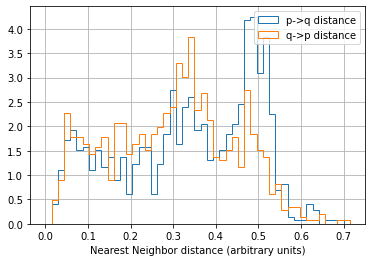

In [12]:
bins50 = np.linspace(0, np.max(d1), 50, endpoint=True)
pl.hist(d1, bins=bins50, density=True, histtype='step', label='p->q distance')
pl.hist(d2, bins=bins50, density=True, histtype='step', label='q->p distance')
pl.legend()
pl.xlabel('Nearest Neighbor distance (arbitrary units)')
pl.grid()

But distances can also be visualized spatially:

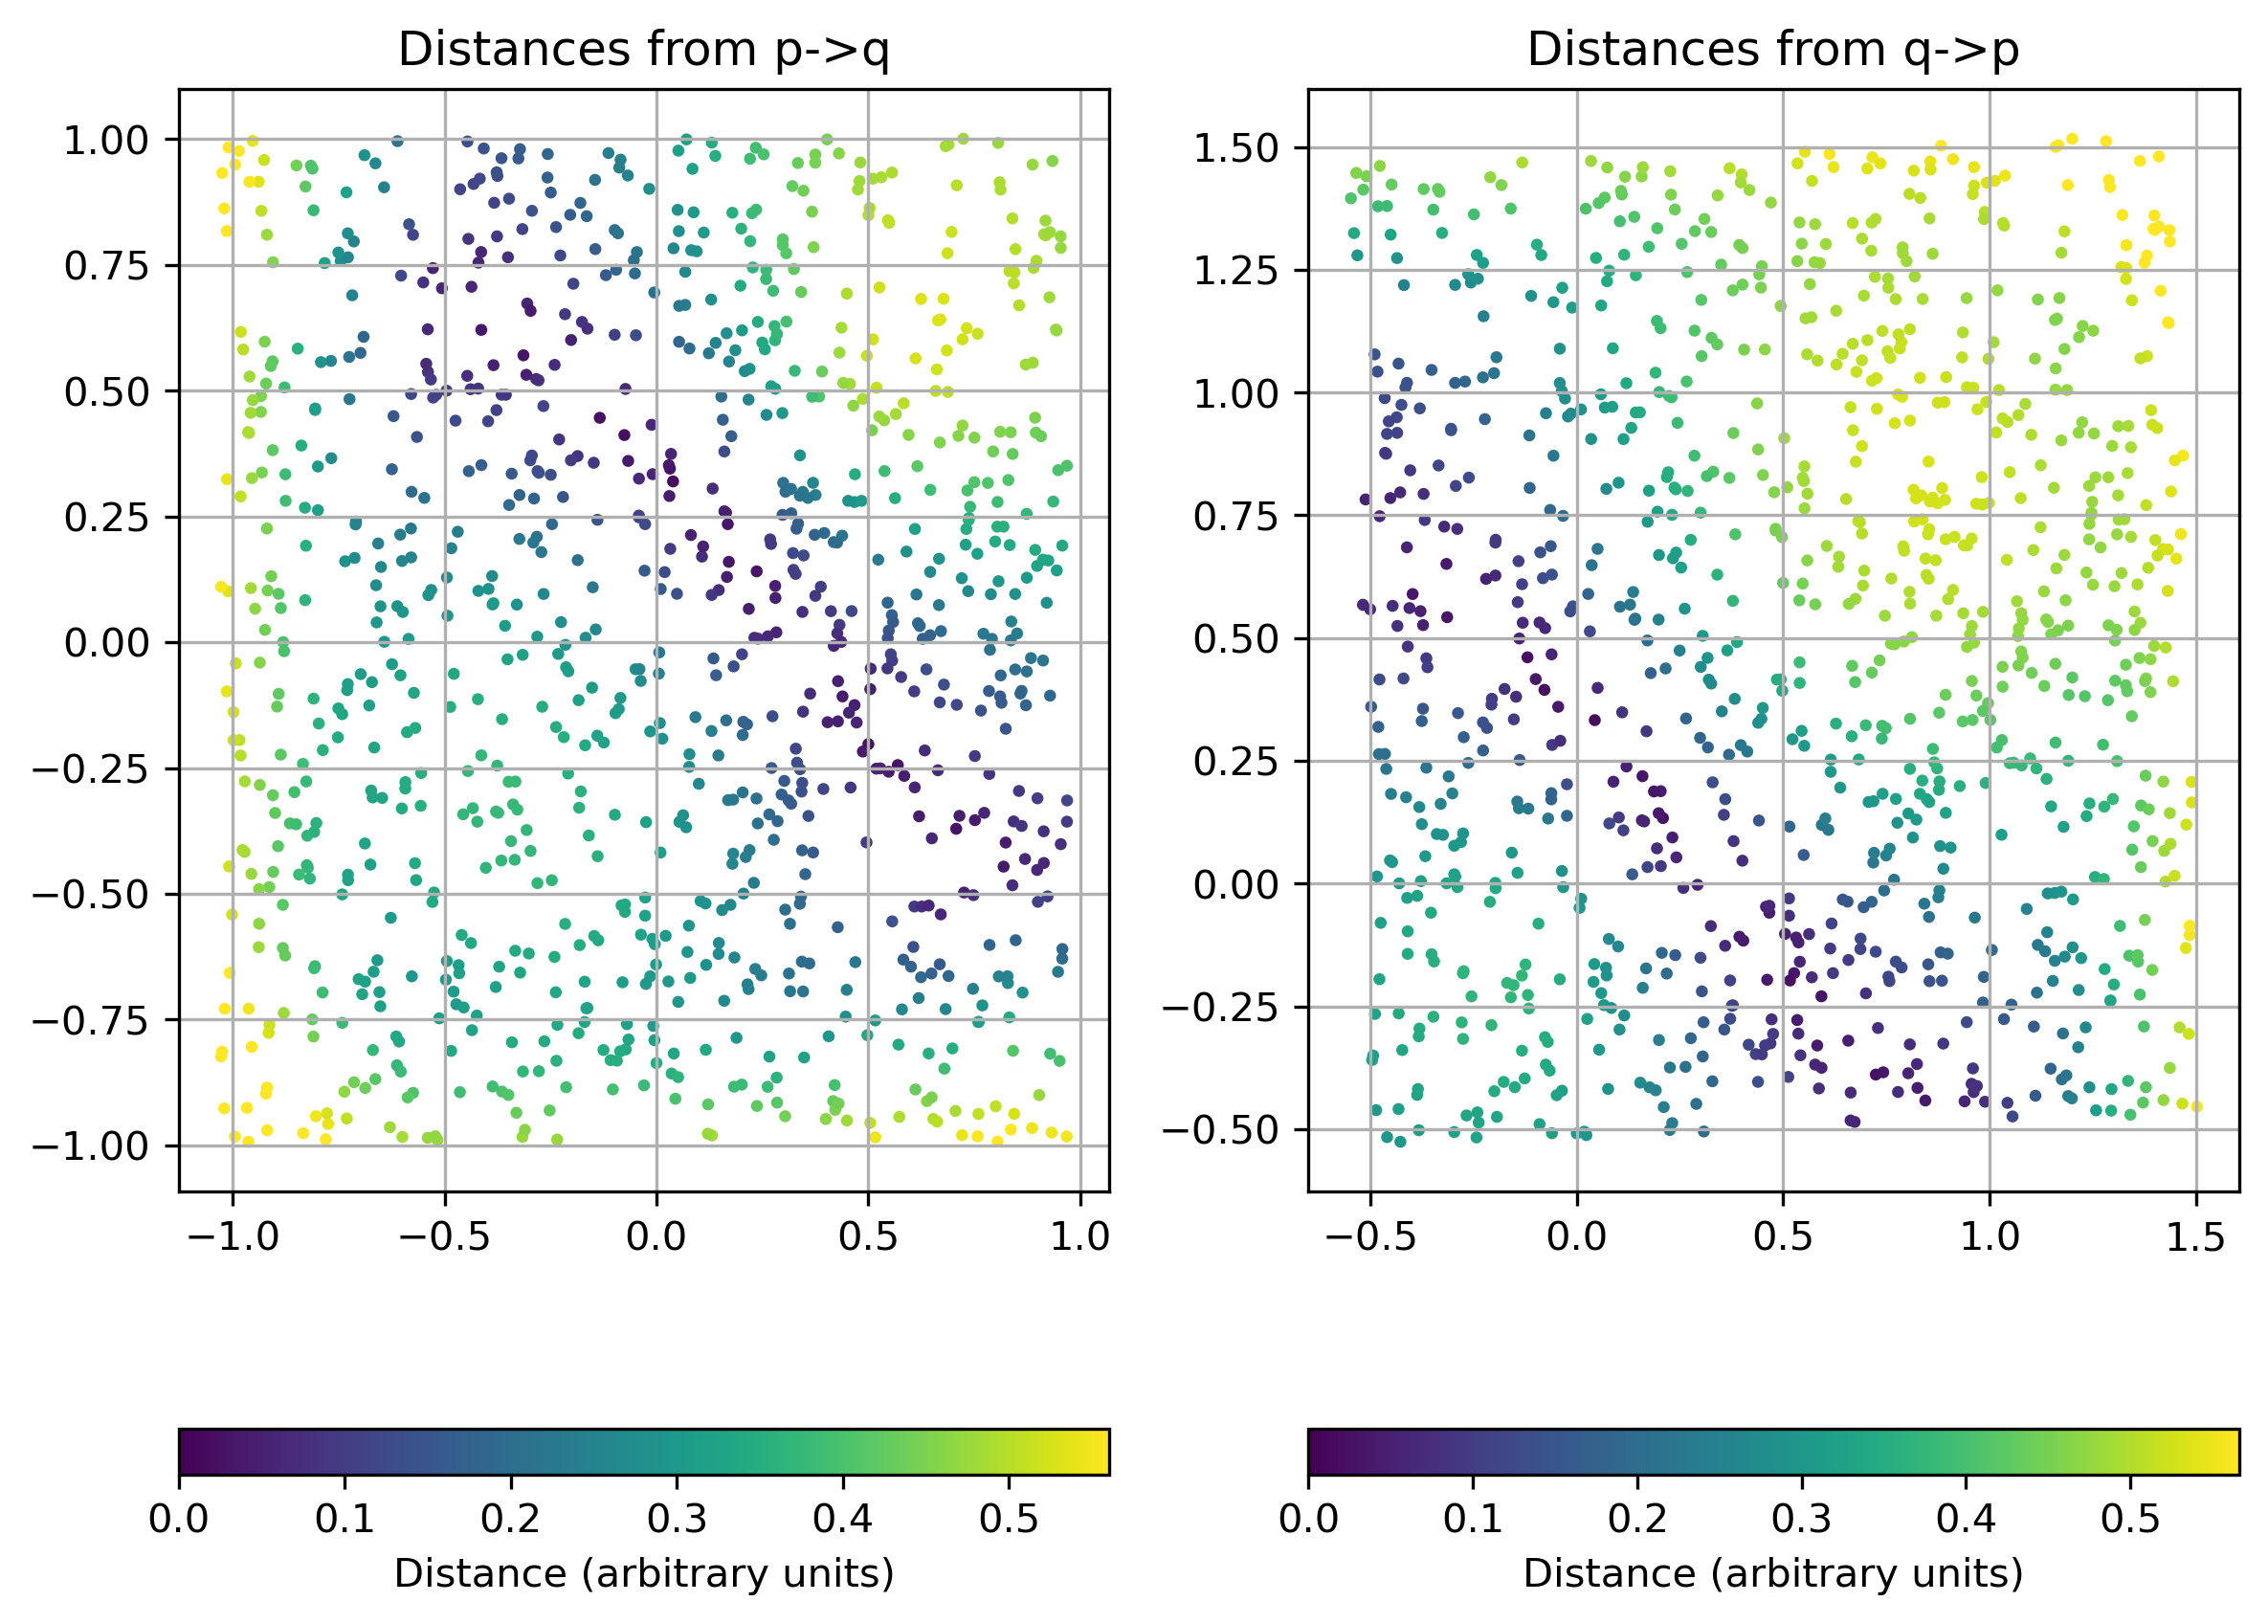

In [13]:
fg, ax = pl.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=300)

#Calculate mean x and y coordinates from point cloud q and subtract
x_mean = np.mean(A[:,0])
y_mean = np.mean(A[:,1])

im0 = ax[0].scatter(A[:,0]-x_mean, 
                   A[:,1]-y_mean, 
           c=d2, s=4, cmap='viridis',
                   vmin=0,
                  vmax=np.percentile(d2,98))
ax[0].grid()
ax[0].set_title('Distances from p->q')
cb0=pl.colorbar(im0, ax=ax[0], orientation='horizontal')
cb0.set_label('Distance (arbitrary units)')

im1 = ax[1].scatter(B[:,0]-x_mean, 
                   B[:,1]-y_mean, 
           c=d1, s=4, cmap='viridis',
                   vmin=0,
                  vmax=np.percentile(d1,98))
ax[1].grid()
ax[1].set_title('Distances from q->p')
cb1=pl.colorbar(im1, ax=ax[1], orientation='horizontal')
cb1.set_label('Distance (arbitrary units)')

fg.tight_layout()

### Hausdorff Distance

Uses the maximum distance between two sets of points. Often described as the **worst case scenario** distance.

[https://en.wikipedia.org/wiki/Hausdorff_distance](https://en.wikipedia.org/wiki/Hausdorff_distance)

$$
d_{H}(X, Y)=\max \left\{\sup _{x \in X} d(x, Y), \sup _{y \in Y} d(X, y)\right\}
$$


In [14]:
Hausdorf_D = np.max([np.max(d1), np.max(d2)])
print(Hausdorf_D)

0.7169852130410057


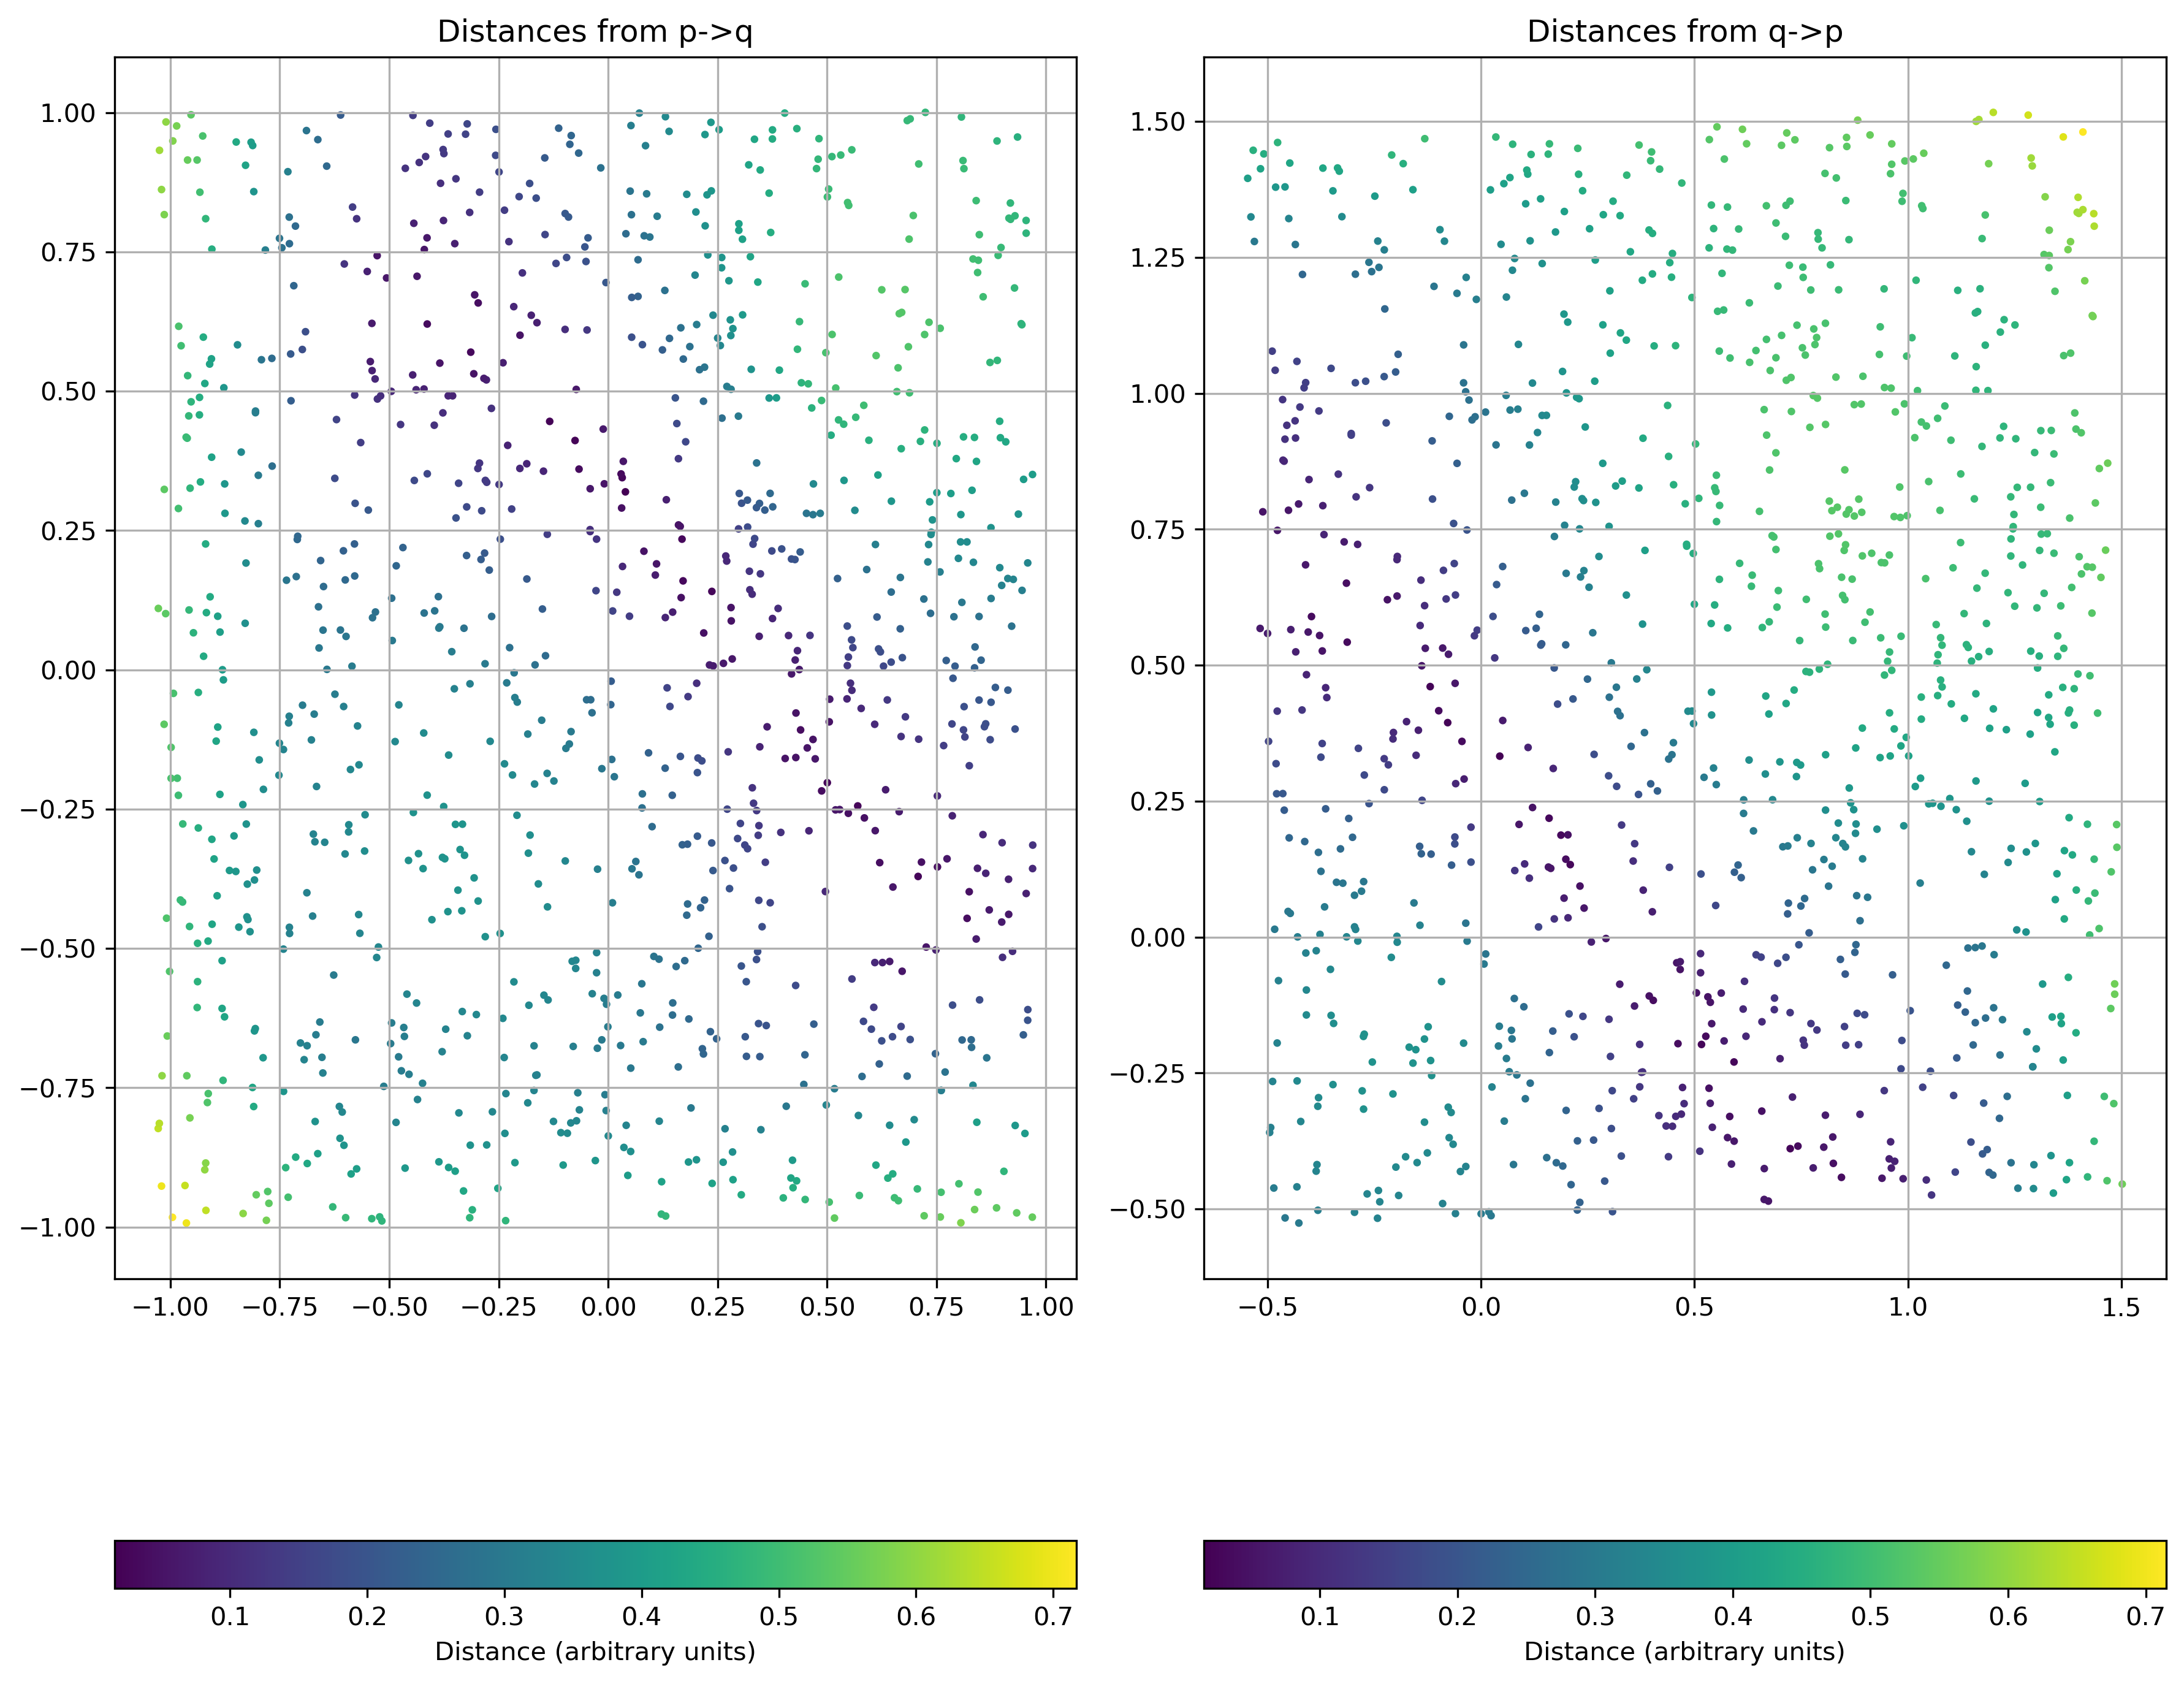

In [15]:
fg, ax = pl.subplots(nrows=1, ncols=2, figsize=(12,10), dpi=300)

#Calculate mean x and y coordinates from point cloud q and subtract
x_mean = np.mean(A[:,0])
y_mean = np.mean(A[:,1])

im0 = ax[0].scatter(A[:,0]-x_mean, 
                   A[:,1]-y_mean, 
           c=d2, s=4, cmap='viridis')
ax[0].grid()
ax[0].set_title('Distances from p->q')
cb0=pl.colorbar(im0, ax=ax[0], orientation='horizontal')
cb0.set_label('Distance (arbitrary units)')

im1 = ax[1].scatter(B[:,0]-x_mean, 
                   B[:,1]-y_mean, 
           c=d1, s=4, cmap='viridis')
ax[1].grid()
ax[1].set_title('Distances from q->p')
cb1=pl.colorbar(im1, ax=ax[1], orientation='horizontal')
cb1.set_label('Distance (arbitrary units)')

fg.tight_layout()

### Modified Hausdorff Distance

Uses the sum of the mean of the minimum distance between two sets of points. Provides a more realistic scenario and is less prone to outliers.

Described in: [https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1.8155&rep=rep1&type=pdf](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1.8155&rep=rep1&type=pdf)


See also: [https://ieeexplore.ieee.org/document/576361](https://ieeexplore.ieee.org/document/576361)
"Based on experiments on synthetic images containing various levels of noise, the authors determined that one of these distance measures, called the modified Hausdorff distance (MHD) has the best performance for object matching."

It requires the calculation of the mean forward and backward distances:
```python
FHD = np.mean(np.min(d1) 
RHD = np.mean(np.min(d2) # Calculating the reverse HD: mean(min(each row))
MHD = np.max(np.array([FHD, RHD])) # Calculating mhd
```

Which can be implemented in a python one-liner:

In [16]:
MHausdorf_D = np.max([np.mean(d1), np.mean(d2)])
print(MHausdorf_D)

0.3370306491291518


### Chamfer Distance

Uses the minimum distance between two sets of points. This is the **best case scenario**.

For each point in each cloud, the Chamfer Distance finds the nearest point in the other point set, and sums up the square of distances.

$$
\operatorname{CD}\left(S_{1}, S_{2}\right)=\frac{1}{\left|S_{1}\right|} \sum_{x \in S_{1}} \min _{y \in S_{\mathbf{z}}}\|x-y\|_{2}^{2}+\frac{1}{\left|S_{2}\right|} \sum_{y \in S_{\mathbf{z}}} \min _{x \in S_{1}}\|x-y\|_{2}^{2}
$$

Usually implemented as a bidirection sum:
$$
sum_{x_i \in x}{\min_{y_j \in y}{||x_i-y_j||**2}} + sum_{y_j \in y}{\min_{x_i \in x}{||x_i-y_j||**2}}
$$

In [17]:
Chamfer_D = np.mean(np.square(d1)) + np.mean(np.square(d2))
print(Chamfer_D)
#print('%2.2e'%Chamfer_D)

0.24778657427785783


Note that the implementation in pdal (see below) is slightly different (using the sum and not the mean) and defined as:

$$
d_{CD}(X,Y) = \sum_{x \in X} \operatorname*{min}_{y \in Y} ||x-y||^2_2 + \sum_{y \in Y} \operatorname*{min}_{x \in X} ||x-y||^2_2
$$

In [19]:
Chamfer_D = np.sum(np.square(d1)) + np.sum(np.square(d2))
print(Chamfer_D)
print('%2.2e'%Chamfer_D)

244.73699002171037
2.45e+02


### Alternative distance evaluation
Using a single value to determine the minimum, averaged, or maximum distance will always be biased. Instead of using a single value, one can look at the entire distance distribution of the nearest neighbor.

There is an implementation of this and this is commonly referred to as *Earth Mover's Distance (EMD)* ([https://en.wikipedia.org/wiki/Earth_mover%27s_distance](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)). It is computationally expensive. There are python implementations available, but these often require CUDA/GPU processing and we are not looking into this in at this point.